In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2, l1
import random

#Regression for predicted yardage NFL
def build():
    network = keras.models.Sequential()
    network.add(Dense(256, activation='relu', input_shape=(x_train.shape[1],), kernel_regularizer=l1(1.e-3)))
    network.add(Dense(152, activation='relu'))
    network.add(Dropout(0.1))
    network.add(Dense(54, activation='relu', kernel_regularizer=l2(1.e-3)))
    network.add(Dense(1, activation = 'linear'))
    network.compile(loss='mse', optimizer="adam" ,metrics=['mean_absolute_error'])
    return network


#Data preparation for regression NFL
def data_prep(data):
    data = pd.get_dummies(data)
    y = data['yards_gained']
    x = data.drop(columns = ['yards_gained'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    cols = ['yardline_100', 'quarter_seconds_remaining', 'ydstogo']
    for x in cols:
        mean = x_train[x].mean(axis=0)
        x_train[x] -= mean
        std = x_train[x].std(axis=0)
        x_train[x] /= std
        x_test[x] -= mean
        x_test[x] /= std
        
    y_train /= 10
    y_test /= 10
    return x_train, x_test, y_train, y_test

#Regression k-cross-validation
def cross_valid_reg(k, num_epochs, x_train, y_train, x_test, y_test):
    samples = len(x_train) // k
    val_history = []
    train_history = []
    for i in range(k):
        data = x_train[i * samples: (i + 1) * samples]
        targets = y_train[i * samples: (i + 1) * samples]
        partial_train_data = np.concatenate([x_train[:i * samples], x_train[(i + 1) * samples:]],axis=0)
        partial_train_targets = np.concatenate([y_train[:i * samples],y_train[(i + 1) * samples:]],axis=0)
        model = build()
        if i == 0:
            print('Input size: ', x_train.shape)
            print(model.summary())
        hist = model.fit(partial_train_data, partial_train_targets, validation_data=(data, targets),
                         epochs=num_epochs, batch_size=100, verbose=0)
        loss_history1 = hist.history['val_loss']
        loss_history2 = hist.history['loss']
        val_history.append(loss_history1)
        train_history.append(loss_history2)
        
    val_history = [np.mean([x[i] for x in val_history]) for i in range(num_epochs)]
    train_history = [np.mean([x[i] for x in train_history]) for i in range(num_epochs)]
    plt.figure(figsize=(12, 8))
    plt.rcParams.update({'font.size': 24})
    plt.plot(range(1, len(val_history) + 1), val_history)
    plt.plot(range(1, len(train_history) + 1), train_history)
    plt.xlabel('Epochs')
    plt.ylabel('loss_function')
    plt.legend(['Validation', 'Training'])
    plt.savefig('YardsNFL.png')
    plt.show()
    _,mae = model.evaluate(x_test, y_test)
    print('Mean Absolute Error of the network is ', mae)
    with open('YardsNFL.txt', 'w') as outfile:
        for x in range(len(val_history)):
            print(x, ' ', val_history[x], ' ', train_history[x], file=outfile)
    
    


Input size:  (80000, 16)
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_92 (Dense)             (None, 256)               4352      
_________________________________________________________________
dense_93 (Dense)             (None, 152)               39064     
_________________________________________________________________
dropout_16 (Dropout)         (None, 152)               0         
_________________________________________________________________
dense_94 (Dense)             (None, 54)                8262      
_________________________________________________________________
dense_95 (Dense)             (None, 1)                 55        
Total params: 51,733
Trainable params: 51,733
Non-trainable params: 0
_________________________________________________________________
None


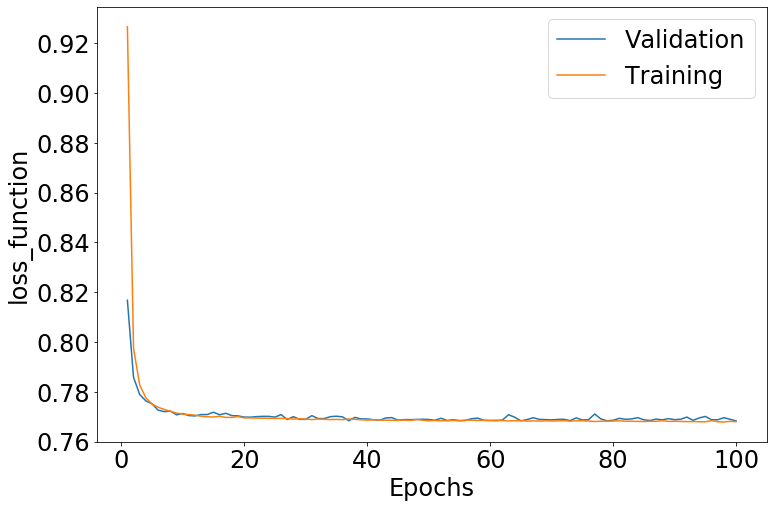

625/625 [==============================] - 1s 1ms/step - loss: 0.7489 - mean_absolute_error: 0.5714
Mean Absolute Error of the network is  0.5714110136032104
Guessing that every play results in set's average gain generates mean absolute error:  0.560286250000014


In [30]:
#NFL Regression for predicted yardage
data = pd.read_csv("data/readyToGo.csv")
data = data.drop(columns = ['posteam', 'defteam', 'game_half', 'posteam_timeouts_remaining',
                            'defteam_timeouts_remaining', 'score_differential'])

x_train, x_test, y_train, y_test = data_prep(data.sample(100000))

#Benchmark
meany = y_train.median()
error = pd.Series(y_train-meany)
error = abs(error)
benchmark = error.mean()

cross_valid_reg(3, 100, x_train, y_train, x_test, y_test)
print('Guessing that every play results in set\'s average gain generates mean absolute error: ', benchmark)



C:\Users\filip\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


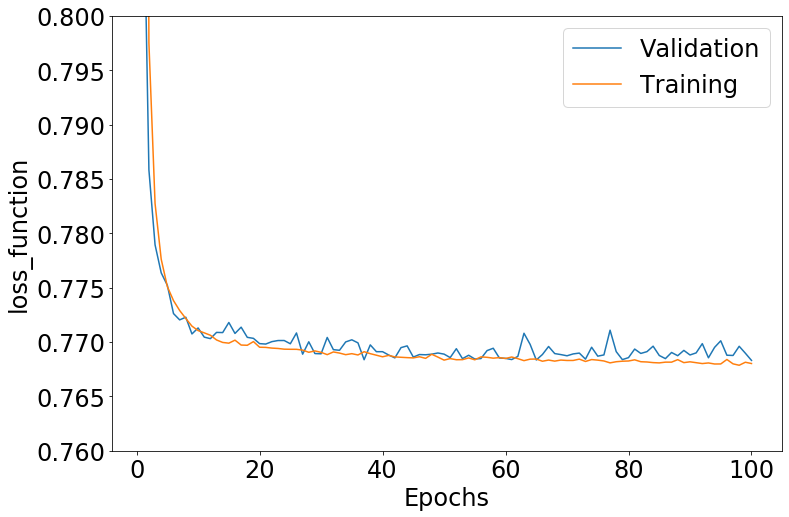

In [35]:
plot = pd.read_csv('YardsNFL.txt', header = None, sep = '  ', names = ['Epochs', 'Validation', 'Training'])
plot = plot.set_index(['Epochs'])

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 24})
plt.plot(range(1, len(plot['Validation']) + 1), plot['Validation'])
plt.plot(range(1, len(plot['Training']) + 1), plot['Training'])
plt.xlabel('Epochs')
plt.ylabel('loss_function')
plt.legend(['Validation', 'Training'])
plt.ylim([0.76,0.8])
plt.savefig('YardsNFL.png')
plt.show()